<a href="https://colab.research.google.com/github/jonasd4/pathology-worked-through/blob/main/cancer_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Worked-Through Example: Cancer classification from images**

This is the code for the first worked-through example: **Cancer classification from images** in our paper *Explainable AI for Precision Pathology*. We will train a model to classify different colorectal patches into tissue classes. The tissue classes are: Adipose (ADI), background (BACK), debris (DEB), lymphocytes (LYM), mucus (MUC), smooth muscle (MUS), normal colon mucosa (NORM), cancer-associated stroma (STR), colorectal adenocarcinoma epithelium (TUM).

In [ ]:
# Clone the repository with the code
!git clone https://github.com/jonasd4/pathology-worked-through
%cd pathology-worked-through

In [ ]:
%cd pathology-worked-through

In [ ]:
# install libraries
!pip install zennit pytorch-lightning

In [2]:
# Imports
import matplotlib.pyplot as plt
from PIL import Image
import os
import random
import pandas as pd
from os.path import join
from tqdm.notebook import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from zennit.torchvision import ResNetCanonizer
from zennit.attribution import Gradient
from zennit.composites import EpsilonGammaBox

After cloning the repository, we need to download the patch dataset which we want to investigate. The original dataset was published by the authors on [Zenodo](https://zenodo.org/record/1214456#.Y_nbuuzMK3J). To speed up the download process, we download a copy from a Google Drive. The downlaod should take about 3 mins.

In [ ]:
## Download data
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1HSANsreKw3sxU7-dLr7c6_5ovexb6LR3' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1HSANsreKw3sxU7-dLr7c6_5ovexb6LR3" -O CRC-VAL-HE-7K.zip && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=14SHepFBNGhNlGhncoT2bvTy5iNkgw9iT' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=14SHepFBNGhNlGhncoT2bvTy5iNkgw9iT" -O NCT-CRC-HE-100K-NONORM.zip && rm -rf /tmp/cookies.txt
!unzip CRC-VAL-HE-7K.zip
!unzip NCT-CRC-HE-100K-NONORM.zip

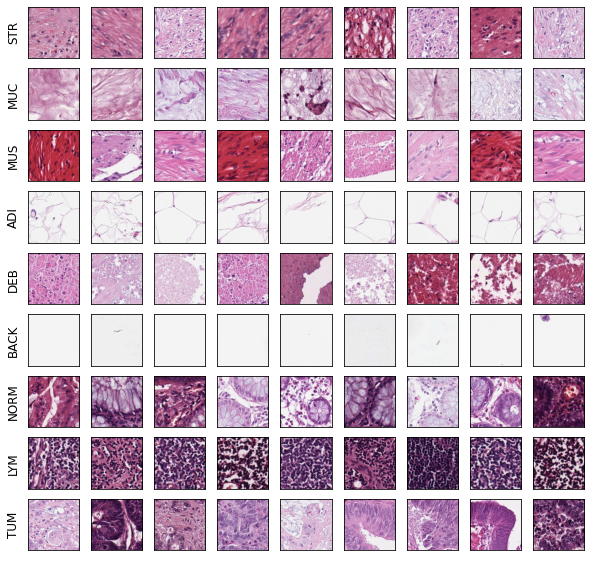

In [4]:
# Show example images from the dataset

path = 'NCT-CRC-HE-100K-NONORM'
classes = list(os.listdir(path))
samples_per_class = 9

fig, ax = plt.subplots(len(classes), samples_per_class)
fig.set_size_inches((10, 10))
for row_idx, cls in enumerate(classes):
  files = os.listdir(os.path.join(path, cls))
  random.shuffle(files)
  for col_idx, file in enumerate(files[:samples_per_class]):
    img = Image.open(os.path.join(path, cls, file))
    ax[row_idx][col_idx].imshow(img)
    ax[row_idx][col_idx].set_yticklabels([])
    ax[row_idx][col_idx].set_xticklabels([])
    ax[row_idx][col_idx].set_xticks([])
    ax[row_idx][col_idx].set_yticks([])
    ax[row_idx][0].set_ylabel(cls, rotation=90, size='large')

## Split the data
We now split the data into a train, test and validation split. The training set  will be 50% of the images and the validation and test set each 25%.

In [19]:
def generate_sub_splits(subdir='NCT-CRC-HE-100K', seed=0):
    path = os.path.join(subdir)
    patches = []
    classes = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']
    for cls in classes:
        cls_path = join(path, cls)
        if cls.endswith('.csv'):
              continue
        for patch in sorted(os.listdir(cls_path)):
            patches.append({
                'file_path': join(cls, patch),
                'cls': cls,
                'label': classes.index(cls),
            })
    df = pd.DataFrame(patches)
    train, other = train_test_split(df, test_size=0.5, random_state=seed)
    validation, test = train_test_split(other, test_size=0.5, random_state=seed)
    df.to_csv(os.path.join(path, 'all.csv'))
    train.to_csv(os.path.join(path, 'train.csv'))
    test.to_csv(os.path.join(path, 'test.csv'))
    validation.to_csv(os.path.join(path, 'validation.csv'))

generate_sub_splits('NCT-CRC-HE-100K-NONORM')
generate_sub_splits('CRC-VAL-HE-7K')

## Train the model
We will now train the model. We use Pytorch and [Pytorch Lightning](https://pytorch-lightning.readthedocs.io/en/stable/) to train our model. The training takes about 1 hour. To continue right away, you can also download the trained model immediately below and follow the rest of the worked-through example.


In [ ]:
# start tensorboard to monitor the full training
%load_ext tensorboard
%tensorboard --logdir logs

In [ ]:
%run train.py --logdir logs/baseline \
--batch_size 32 \
--learning-rate 0.01 \
--weight-decay 0.001 \
--epochs 300 \
--classes 9 \
--loss ce \
--train-split train \
--test-split validation \
--train-path NCT-CRC-HE-100K-NONORM \
--test-path NCT-CRC-HE-100K-NONORM \
--val-interval 10 \
--num_workers 4 \
--augmentation v2

In [8]:
# Download the model
checkpoint_path = 'simple_model.ckpt'
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1fl3X8Cd3Ghgwkvy_b3-EA5nC9hhcOj5s' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1fl3X8Cd3Ghgwkvy_b3-EA5nC9hhcOj5s" -O simple_model.ckpt && rm -rf /tmp/cookies.txt

--2023-02-28 17:52:32--  https://docs.google.com/uc?export=download&confirm=t&id=1fl3X8Cd3Ghgwkvy_b3-EA5nC9hhcOj5s
Resolving docs.google.com (docs.google.com)... 74.125.197.101, 74.125.197.139, 74.125.197.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.197.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-84-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/67d4k29ie6ib48pe9s2csg803nhcvu0l/1677606750000/17131568452943341012/*/1fl3X8Cd3Ghgwkvy_b3-EA5nC9hhcOj5s?e=download&uuid=bcb583c3-664d-480d-bdf0-3d3665770a0c [following]
--2023-02-28 17:52:32--  https://doc-04-84-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/67d4k29ie6ib48pe9s2csg803nhcvu0l/1677606750000/17131568452943341012/*/1fl3X8Cd3Ghgwkvy_b3-EA5nC9hhcOj5s?e=download&uuid=bcb583c3-664d-480d-bdf0-3d3665770a0c
Resolving doc-04-84-docs.googleusercontent.com (doc-04-84-docs.googleusercontent.com)... 74.125.20.132, 2

## Evaluate
After training the model, we evaluate the model which best performed on the validation set on the test set. Further, we also evaluate on the external test set which comes from a different set of patients.


In [21]:
from datasets import PatchDataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import resnet18
from collections import OrderedDict
import torch

def load_model(checkpoint_path, device='cuda'):
    # We load the model from the pytorch checkpoint
    checkpoint = torch.load(checkpoint_path)
    model = resnet18()
    model.fc = torch.nn.Linear(512, 9)
    new_state_dict = OrderedDict()
    for key, value in checkpoint['state_dict'].items():
        new_key = key.replace('model.', '')
        new_state_dict[new_key] = value
    model.load_state_dict(new_state_dict)
    model.eval()
    model = model.to(device)
    return model

def evaluate(model, dataset_path='CRC-VAL-HE-7K', split='df', device='cuda'):
    # test preprocessing
    IMAGENET_NORM = [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
    test_aug = transforms.Compose([
                    transforms.Resize(224),
                    transforms.ToTensor(),
                    transforms.Normalize(*IMAGENET_NORM)
              ])

    # setup dataset
    test_ds = PatchDataset(root=dataset_path, split=split, transform=test_aug)
    test_dl = DataLoader(test_ds, batch_size=64, num_workers=8)

    # compute accuracy on the test set
    predictions = []
    Y = []
    with torch.no_grad():
        for x, y in tqdm(test_dl):
            x = x.to(device)
            pred = torch.argmax(model(x), dim=-1)
            Y.append(y)
            predictions.append(pred)
    Y = torch.cat(Y)
    predictions = torch.cat(predictions).detach().cpu()
    accuracy = (predictions == Y).sum() / len(predictions)
    return accuracy.numpy().item()
  
model = load_model(checkpoint_path)
print("accuracy on the validation set: ", evaluate(model, 'NCT-CRC-HE-100K-NONORM', 'validation'))
print("accuracy on the test set: ", evaluate(model, 'NCT-CRC-HE-100K-NONORM', 'test'))
print("accuracy on the external test set: ", evaluate(model, 'CRC-VAL-HE-7K', 'all'))

  0%|          | 0/113 [00:00<?, ?it/s]

accuracy on the external test set:  0.332172691822052


## Investigate the model with XAI
To understand the poor performance of the classifier on the external test set, we apply Explainable AI, and generate for a handful of predictions of our model a heatmap indicating the contribution of individual pixels to these predictions. We use the LRP technique implemented in the [zennit](https://github.com/chr5tphr/zennit) framework to compute heatmaps.

In [ ]:
def show_lrp_heatmaps(model, dataset):
  indices = list(range(len(dataset)))
  random.shuffle(indices)
  count = 0
  for k in tqdm(indices[:10]):
      sample, label = dataset[k]
      relevances = []
      labels = []
      predictions = []
      model = model.to('cpu')
      input = sample.unsqueeze(0)
      input.requires_grad = True
      model.zero_grad()
      canonizers = [ResNetCanonizer()]
      composite = EpsilonGammaBox(low=-1, high=1, canonizers=canonizers)
      indices = []
      
      with torch.no_grad():
          pred = torch.argmax(model(input)).numpy().item()
      
      target = torch.eye(9)[[pred]]
      
      with Gradient(model, composite) as attributor:
          output, relevance = attributor(input, target)
          relevance = relevance.squeeze(0).numpy()
          relevances.append(relevance)
          
          predictions.append(round(torch.argmax(output).detach().numpy().item(), 2))
          labels.append(label)
      
      fig, ax = plt.subplots(1, 2)
      fig.set_size_inches((10, 5))
      ax[0].imshow(torch.permute(inverse_normalize(sample, mean=IMAGENET_NORM[0], std=IMAGENET_NORM[1]), (1, 2, 0)))
      for i in range(len(relevances)):
          b = 10 * ((np.abs(relevances[i])**4).mean()**(1.0/4))
          ax[i + 1].imshow(relevances[i].sum(axis=0), cmap=my_cmap, vmin=-b, vmax=b)
      for a in ax:
          a.axis('off')
      plt.show()

## Look at the color spectrum of the images

Reliance on color distribution rather than the more predictive geometrical shapes is a common Clever Hans strategy as the former is usually much easier to learn by a model than the latter. To further understand the emergence of this Clever Hans strategy, we conduct a simple additional experiment where we represent each image by its average color (a three-dimensional vector containing the pixel-wise mean of the red, green, and blue channels respectively). The following code computes the average of 2000 randomly chosen samples and visualizes the mean color in a PCA biplot.

0it [00:00, ?it/s]

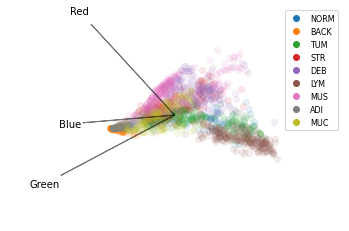

In [27]:
path = 'NCT-CRC-HE-100K-NONORM'
df = pd.read_csv(join(path, 'train.csv'))

# we sample 2000 random samples for better visualization purposes
subset = df.sample(2000)

def compute_color_means():
  colors = []
  for idx, row in tqdm(subset.iterrows()):
      img = Image.open(join(path, row['file_path']))
      img_array = np.asarray(img)
      avg_color_per_row = np.average(np.asarray(img), axis=0)
      avg_color = np.average(avg_color_per_row, axis=0)
      colors.append(avg_color)
  colors = np.array(colors)
  return colors

X = compute_color_means()
y = subset.label
scaler = StandardScaler()
scaler.fit(X)   
pca = PCA()
x_new = pca.fit_transform(X)

def pca_biplot(score, coeff, labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1./(xs.max() - xs.min())
    scaley = 1./(ys.max() - ys.min())
    
    for label in subset.label.unique():
        legend_label = str(subset[subset.label == label].cls.unique()[0])
        mask = subset.label == label
        scatter = plt.scatter(xs[mask] * scalex, ys[mask] * scaley, alpha=0.1, label=legend_label)
    
    colors = ['red', 'green', "blue"]
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color = 'black', alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'black', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.axis("off")
    leg = plt.legend(loc="upper right", fontsize=8)
    for lh in leg.legendHandles:
        lh.set_alpha(1)

pca_biplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]), labels=['Red', 'Green', "Blue"])
plt.show()

## Stain normalization
Now that we identified that color seems to be a strong problem in this case, we can use stain normalization to map all images ot the same color space. We use the [Macenko](https://www.cs.unc.edu/~mn/sites/default/files/macenko2009.pdf) method and the [torchstain](https://github.com/EIDOSLAB/torchstain) library.

In [ ]:
%run stain.py --ref Ref.png --img NCT-CRC-HE-100K-NONORM \
--out NCT-CRC-HE-100K-stain-norm

In [ ]:
# show pca biplot of stain normalized dataset

## Train the improved model
We train the improved model with the stain normalized images and color augmentations (v3).

In [ ]:
%run train.py --logdir logs/improved \
--batch_size 32 \
--learning-rate 0.01 \
--weight-decay 0.001 \
--epochs 300 \
--classes 9 \
--loss ce \
--train-split train \
--test-split test \
--train-path NCT-CRC-HE-100K-stain-norm \
--test-path NCT-CRC-HE-100K-stain-norm \
--val-interval 10 \
--num_workers 4 \
--augmentation v3 # now we use also color augmentations

## Verify the improved performance

After training the improved model, we want to verify if our changes (stain normalization, color augmentations) indeed improved the generalizability on the external test set. Therefore, we 

In [ ]:
# evaluate improved model
print("accuracy on the validation set: ", evaluate('NCT-CRC-HE-100K-stain-norm', 'validation'))
print("accuracy on the test set: ", evaluate('NCT-CRC-HE-100K-stain-norm', 'test'))
print("accuracy on the external test set: ", evaluate('CRC-VAL-HE-7K', 'df'))

# show heatmaps of improved model